# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import cv2
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.random.set_seed(30)
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
source_path = 'Project_data/train'

In [5]:
'''
# different image sizes in the dataset
sizes = []
for i in range(len(train_doc)):
    imgs = os.listdir(source_path+'/'+ train_doc[i].split(';')[0])
    for image in imgs:
        pic = imread(source_path+'/'+ train_doc[i].strip().split(';')[0]+'/'+image).astype(np.float32)
        if pic.shape not in sizes:
            sizes.append(pic.shape)


print(sizes)
'''

"\n# different image sizes in the dataset\nsizes = []\nfor i in range(len(train_doc)):\n    imgs = os.listdir(source_path+'/'+ train_doc[i].split(';')[0])\n    for image in imgs:\n        pic = imread(source_path+'/'+ train_doc[i].strip().split(';')[0]+'/'+image).astype(np.float32)\n        if pic.shape not in sizes:\n            sizes.append(pic.shape)\n\n\nprint(sizes)\n"

In [6]:
def shape_image(img,height,width):
    
    if img.shape[0] != height and img.shape[1] != width:
                    h, w, _ = img.shape
                    img = cv2.resize(img, (width,height), interpolation = cv2.INTER_AREA)
    return img

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(5,25)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        number_of_data_points = len(folder_list)
        num_batches = number_of_data_points // batch_size # calculate the number of batches
        for batch in range(num_batches):# we iterate over the number of batches
            # we are going to use 120*160 size of image
            batch_data = np.zeros((batch_size,len(img_idx),120,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = shape_image(image,120,160)
                    
                    #normalising the images. As these are natural imgs, divide by 255 will work
                    batch_data[folder,idx,:,:,0] = image[:,:,0] / 255 
                    batch_data[folder,idx,:,:,1] = image[:,:,1] / 255
                    batch_data[folder,idx,:,:,2] = image[:,:,2] / 255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if number_of_data_points % batch_size == 0:
            pass
        else:
            data_points_remained = number_of_data_points % batch_size
            last_datapoint_included = batch_size * num_batches
            batch_data = np.zeros((data_points_remained,len(img_idx),120,160,3))
            batch_labels = np.zeros((data_points_remained,5))
            
            for folder in range(data_points_remained):
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = shape_image(image,120,160)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] / 255
                    batch_data[folder,idx,:,:,1] = image[:,:,1] / 255
                    batch_data[folder,idx,:,:,2] = image[:,:,2] / 255
                    
                batch_labels[folder, int(t[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
# 20 is the number of images we are taking for each video - 20 (img_idx)
# shape of each image is 120*160 and each image has 3 channels
sample_shape = (20, 120, 160, 3)

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1,l2


#write your model here
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.SGD(lr=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 18, 118, 158, 32)  2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 59, 79, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 59, 79, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 57, 77, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 28, 38, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 28, 38, 64)     256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 26, 36, 128)    221312    
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2,patience=3, min_lr=0.001) 
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/trainEpoch 1/50
 ; batch size = 32
 - 53s - loss: 1.1766 - categorical_accuracy: 0.4977 - val_loss: 1.6137 - val_categorical_accuracy: 0.3900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.39000, saving model to model_init_2020-11-0214_27_29.496584/model-00001-1.18107-0.49623-1.61373-0.39000.h5
Epoch 2/50
 - 41s - loss: 0.5102 - categorical_accuracy: 0.8267 - val_loss: 0.8097 - val_categorical_accuracy: 0.7000

Epoch 00002: val_categorical_accuracy improved from 0.39000 to 0.70000, saving model to model_init_2020-11-0214_27_29.496584/model-00002-0.51488-0.82504-0.80969-0.70000.h5
Epoch 3/50
 - 43s - loss: 0.1300 - categorical_accuracy: 0.9672 - val_loss: 0.7522 - val_categorical_accuracy: 0.7200

Epoch 00003: val_categorical_accuracy improved from 0.70000 to 0.72000, saving model to model_init_2020-11-0214_27_29.496584/model-00003-0.13112-0.96682-0.75223-0.72000.h5
Epoch 4/50
 - 44s - loss: 0.

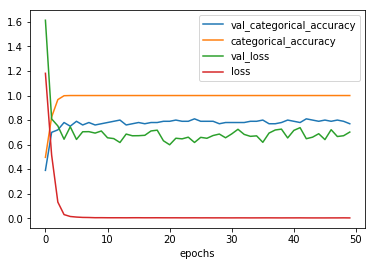

In [16]:
plt.plot(model.history.history['val_categorical_accuracy'],label='val_categorical_accuracy')
plt.plot(model.history.history['categorical_accuracy'],label='categorical_accuracy')
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.plot(model.history.history['loss'],label='loss')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()